# Anomalie globale de température (ERA5 1940-2022)

**Auteur : Frédéric FERRY (ENM) - septembre 2023**

Données mensuelles de température issues des réanalyses ERA5 : https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form

**Attention : le traitement des données globales ERA5 à la résolution 0.25° nécessite beaucoup de mémoire**

In [30]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.gridspec as gridspec
from matplotlib.cm import get_cmap

import xarray as xr

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

from tqdm import tqdm

In [31]:
t    = xr.open_dataset("./data/era5.t2m.mon.1940-2022.nc")
print(t)
time=t.time.values

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 996)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-06 15:31:58 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...


In [32]:
t2   = xr.open_dataset("./data/era5.t2m.mon.1940-2022.nc").sel(time=slice('1991','2020'))
t_clim=t2.groupby('time.month').mean('time')
print("----- Computing monthly anomalies -----")
tanom=t.groupby('time.month')-t_clim
print("----- Done -----")

----- Computing monthly anomalies -----
----- Done -----


In [33]:
def lonflip(da):
    lon_name = 'longitude'
    da['_longitude_adjusted'] = xr.where(
        da[lon_name] > 180,
        da[lon_name] - 360,
        da[lon_name])
    da = (
        da
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(da._longitude_adjusted)})
        .drop(lon_name))
    da = da.rename({'_longitude_adjusted': lon_name})
    return da

In [34]:
year=input("Entrer l'année souhaitée : ")

t_year=t.sel(time=year)
tanom_year=tanom.sel(time=year)

data=t_year['t2m'][:,:,:]
data_anom=tanom_year['t2m'][:,:,:]
data_clim=t_clim['t2m'][:,:,:]

data = lonflip(data)
data_anom = lonflip(data_anom)
data_clim = lonflip(data_clim)

print(data.shape)
print(data_anom.shape)
print(data_clim.shape)

lat=data.latitude.values
lon=data.longitude.values

Entrer l'année souhaitée : 2022
(12, 721, 1440)
(12, 721, 1440)
(12, 721, 1440)


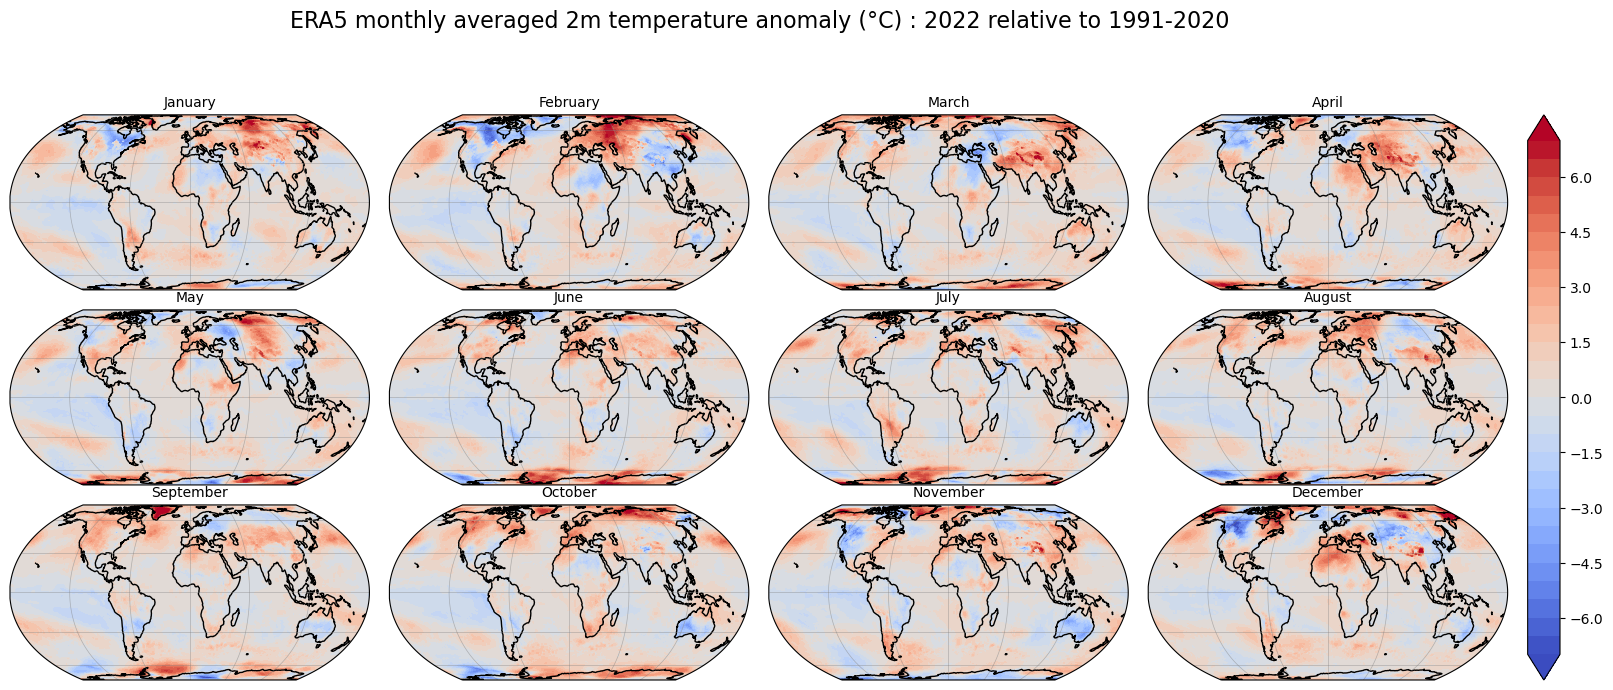

In [35]:
months=['January','February','March','April','May','June','July',
       'August','September','October','November','December']

def plot_background(ax):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    return ax

proj=ccrs.EqualEarth()

levels=np.arange(-7,7.5, 0.5)

axes_class = (GeoAxes, dict(map_projection=proj))
fig = plt.figure(figsize=(20,8))
fig.suptitle('ERA5 monthly averaged 2m temperature anomaly (°C) : '+year+ ' relative to 1991-2020', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(3, 4),
       axes_pad=0.2,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    plot_background(ax)
    ax.set_title(months[i], fontsize=10)
    p1 = ax.contourf(lon, lat, data_anom[i,:,:], levels=levels, transform=ccrs.PlateCarree(),
                    cmap='coolwarm', extend='both')
    axgr.cbar_axes[i].colorbar(p1)

plt.show()

figname='./figs/ERA5_Tanom_monthly_'+year
fig.savefig(figname+'.png',bbox_inches='tight')

In [37]:
imonth=int(input("Entrer le numéro du mois souhaité (1-12) : "))

Entrer le numéro du mois souhaité (1-12) : 12


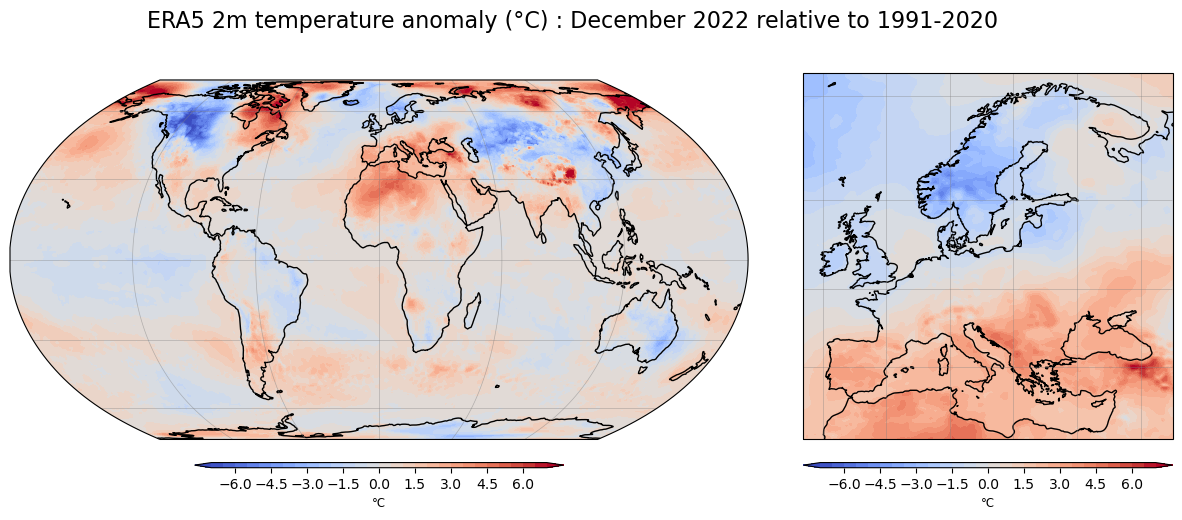

In [38]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('ERA5 2m temperature anomaly (°C) : '+months[imonth-1]+' '+year+' relative to 1991-2020', fontsize=16)

gs = gridspec.GridSpec(1, 2, wspace=0.1, width_ratios=[2,1])
ax = fig.add_subplot(gs[0,0], projection = proj)
plot_background(ax)
p1 = ax.contourf(lon, lat, data_anom[imonth-1,:,:], levels=levels, transform=ccrs.PlateCarree(),
                 cmap='coolwarm', extend='both')
cb = fig.colorbar(p1, orientation='horizontal', aspect=65, shrink=0.5, pad=0.05)
cb.set_label('°C', size='small')   

ax = fig.add_subplot(gs[0,1], projection = ccrs.Miller())
bounds = [(-13, 45, 30, 72)]
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
plot_background(ax)
p1 = ax.contourf(lon, lat, data_anom[imonth-1,:,:], levels=levels, transform=ccrs.PlateCarree(),
                 cmap='coolwarm', extend='both')
cb = fig.colorbar(p1, orientation='horizontal', aspect=65, shrink=1, pad=0.05)
cb.set_label('°C', size='small')   
plt.show()

figname='./figs/ERA5_Tanom_'+year+'-'+str(imonth)
fig.savefig(figname+'.png',bbox_inches='tight')

Calcul des valeurs globales annuelles (Latitude Area Weighted Global Average)
https://phzoe.com/2022/06/23/python-netcdf-latitude-area-weighted-global-average/

In [39]:
data_annual=data.mean(axis=0)
data_anom_annual=data_anom.mean(axis=0)
data_clim_annual=data_clim.mean(axis=0)

a = 6378.137; e = 1-6356.752**2/a**2; r = np.pi/180 
by_lat = (a*r)**2*(1-e)*np.cos(r*data_annual.latitude)/(1-e*np.sin(r*data_annual.latitude)**2)**2
glob = data_annual.weighted(by_lat).mean({'longitude','latitude'})-273.15
glob_anom = data_anom_annual.weighted(by_lat).mean({'longitude','latitude'})
glob_clim = data_clim_annual.weighted(by_lat).mean({'longitude','latitude'})-273.15

print("Température globale moyenne de l'année choisie :", float(glob))
print("Anomalie moyenne globale de température pour l'année choisie :", float(glob_anom))
print("Température moyenne climatologique :", float(glob_clim))

Température globale moyenne de l'année choisie : 14.620958566945205
Anomalie moyenne globale de température pour l'année choisie : 0.3018131823595455
Température moyenne climatologique : 14.319178290169418


https://climate.copernicus.eu/surface-air-temperature-december-2022

Averaging over twelve-month periods smooths out shorter-term variations in regional- and global-average temperatures. Globally, 2022 was 0.30°C warmer than the 1991-2020 average. The warmest calendar year is 2016, with a temperature of 0.44°C above the 1991-2020 average. 2020 was on a par with 2016, being cooler by less than 0.01°C, well below the spread among multiple datasets. The third and fourth warmest calendar years are 2019 and 2017, and their temperatures were 0.40°C and 0.34°C above average, respectively. 2022 was the fifth warmest on record at 0.30°C above average, but was only marginally warmer than the years 2015, 2018, and 2021;

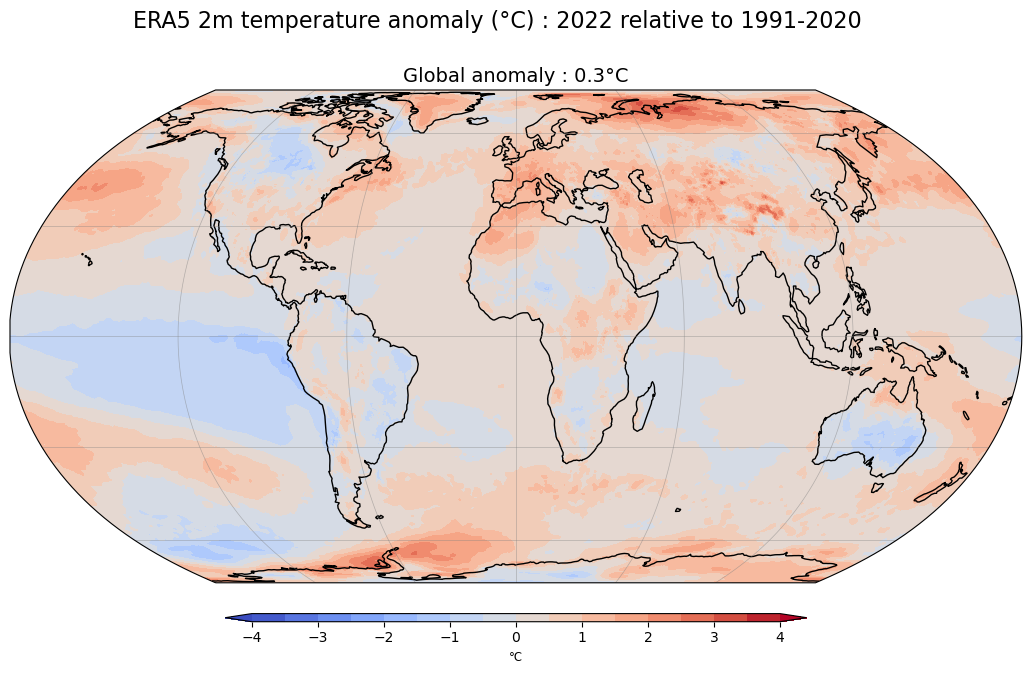

In [40]:
levels=np.arange(-4,4.5, 0.5)

fig = plt.figure(figsize=(15,8))
fig.suptitle('ERA5 2m temperature anomaly (°C) : '+year+ ' relative to 1991-2020', fontsize=16)
ax = fig.add_subplot(1, 1, 1, projection=proj)
plot_background(ax)
ax.set_title('Global anomaly : '+str(round(float(glob_anom),2))+'°C', fontsize=14)
p1 = ax.contourf(lon, lat, data_anom_annual, levels=levels, transform=ccrs.PlateCarree(),
                 cmap='coolwarm', extend='both')
cb = fig.colorbar(p1, orientation='horizontal', aspect=65, shrink=0.5, pad=0.05)
cb.set_label('°C', size='small')   
plt.show()

figname='./figs/ERA5_Tanom_'+year
fig.savefig(figname+'.png',bbox_inches='tight')

In [41]:
year_list =[str(i) for i in range(1940,2023)]
year_int=np.arange(1940,2023)
print(year_int)

[1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953
 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967
 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981
 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [42]:
GLOB=[]
GLOB_A=[]

for y in tqdm(range(len(year_list))):
    t_year=t.sel(time=year_list[y])
    tanom_year=tanom.sel(time=year_list[y])
    data=t_year['t2m'][:,:,:]
    data_anom=tanom_year['t2m'][:,:,:]
    data_annual=data.mean(axis=0)
    data_anom_annual=data_anom.mean(axis=0)
    a = 6378.137; e = 1-6356.752**2/a**2; r = np.pi/180 
    by_lat = (a*r)**2*(1-e)*np.cos(r*data_annual.latitude)/(1-e*np.sin(r*data_annual.latitude)**2)**2
    glob = data_annual.weighted(by_lat).mean({'longitude','latitude'})-273.15
    glob_anom = data_anom_annual.weighted(by_lat).mean({'longitude','latitude'})
    GLOB.append(glob)
    GLOB_A.append(glob_anom)

100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [01:09<00:00,  1.19it/s]


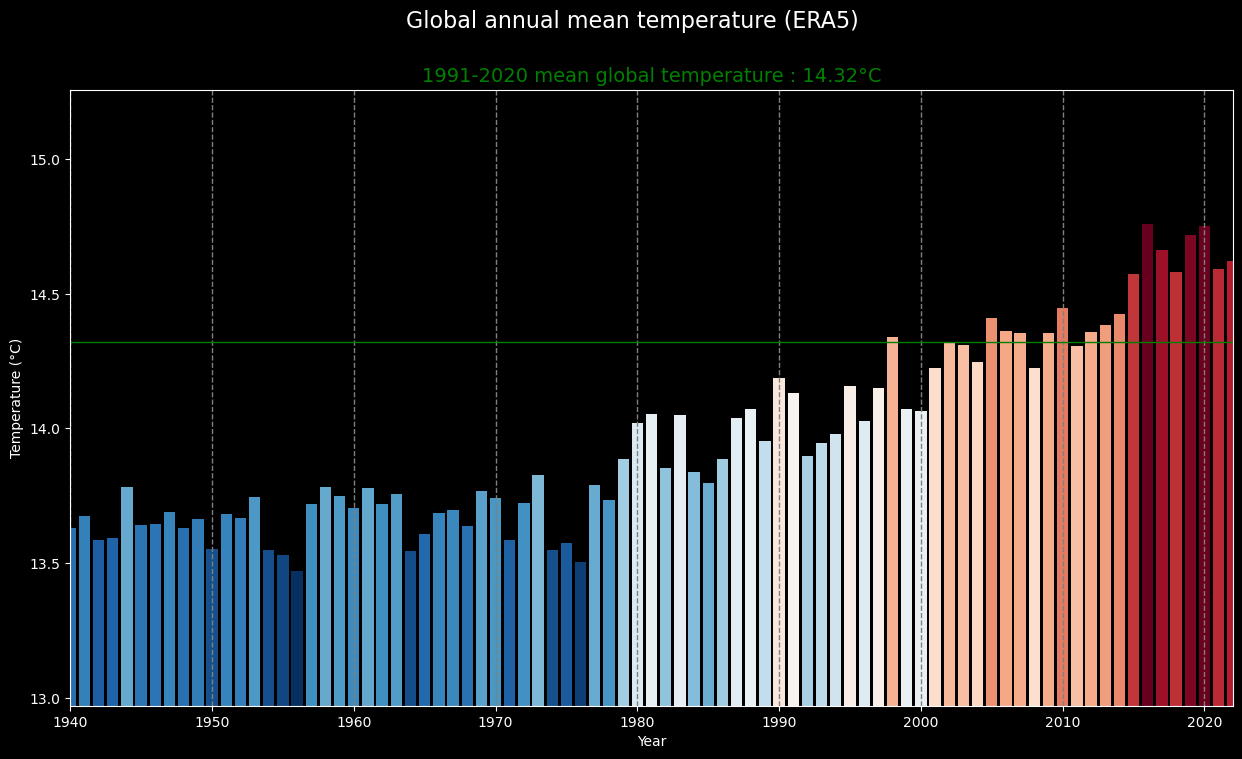

In [43]:
denominator = max(GLOB) - min(GLOB)
scaled_data = [(datum-min(GLOB))/denominator for datum in GLOB]
colors = []
cmap = get_cmap('RdBu_r')
for decimal in scaled_data:
    colors.append(cmap(decimal))

plt.style.use('dark_background')
    
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
fig.suptitle('Global annual mean temperature (ERA5)', fontsize=16)
ax.set_title('1991-2020 mean global temperature : '+str(round(float(glob_clim),2))+'°C', fontsize=14, color='green')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.bar(year_int, np.transpose(GLOB), color=colors)
xcoords = np.arange(1940,2030,10)
plt.ylim(min(GLOB)-0.5,max(GLOB)+0.5)
for xc in xcoords:
    plt.axvline(x=xc,linewidth=1, linestyle='--', color='grey')
plt.axhline(y=glob_clim,linewidth=1, linestyle='-', color='green')
plt.xlim(year_int[0],year_int[-1])
plt.show()

figname='./figs/ERA5_GLOB_T'
fig.savefig(figname+'.png',bbox_inches='tight')

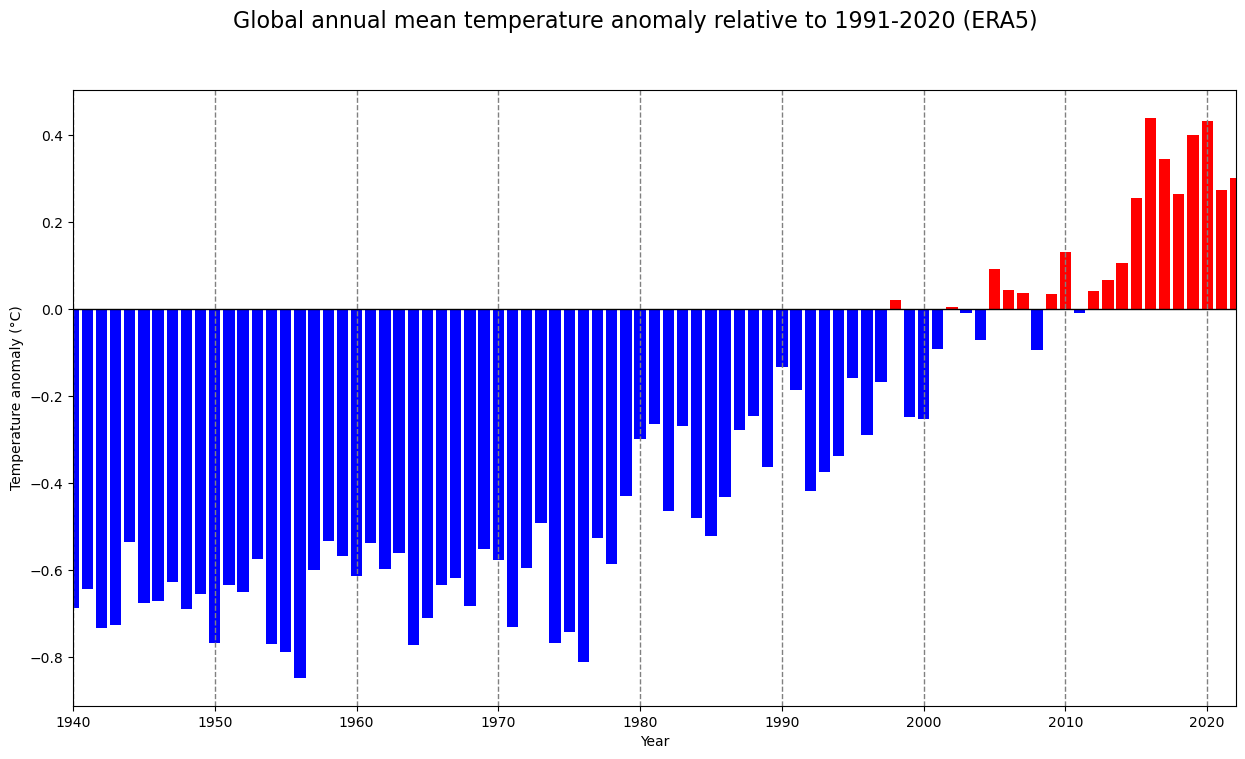

In [44]:
plt.style.use('default')

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
fig.suptitle('Global annual mean temperature anomaly relative to 1991-2020 (ERA5)', fontsize=16)

plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.axhline(0, linewidth=1, color='k')
plt.xlim(year_int[0],year_int[-1])
colormat=np.where(np.transpose(GLOB_A)>0, 'red','blue')
plt.bar(year_int, np.transpose(GLOB_A),color=colormat)
xcoords = np.arange(1940,2030,10)
for xc in xcoords:
    plt.axvline(x=xc,linewidth=1, linestyle='--', color='grey')
plt.show()

figname='./figs/ERA5_GLOB_TANOM'
fig.savefig(figname+'.png',bbox_inches='tight')

----- Years 1940-2015 -----


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [01:09<00:00,  1.07it/s]


----- Years 2016-2023 -----


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.04it/s]


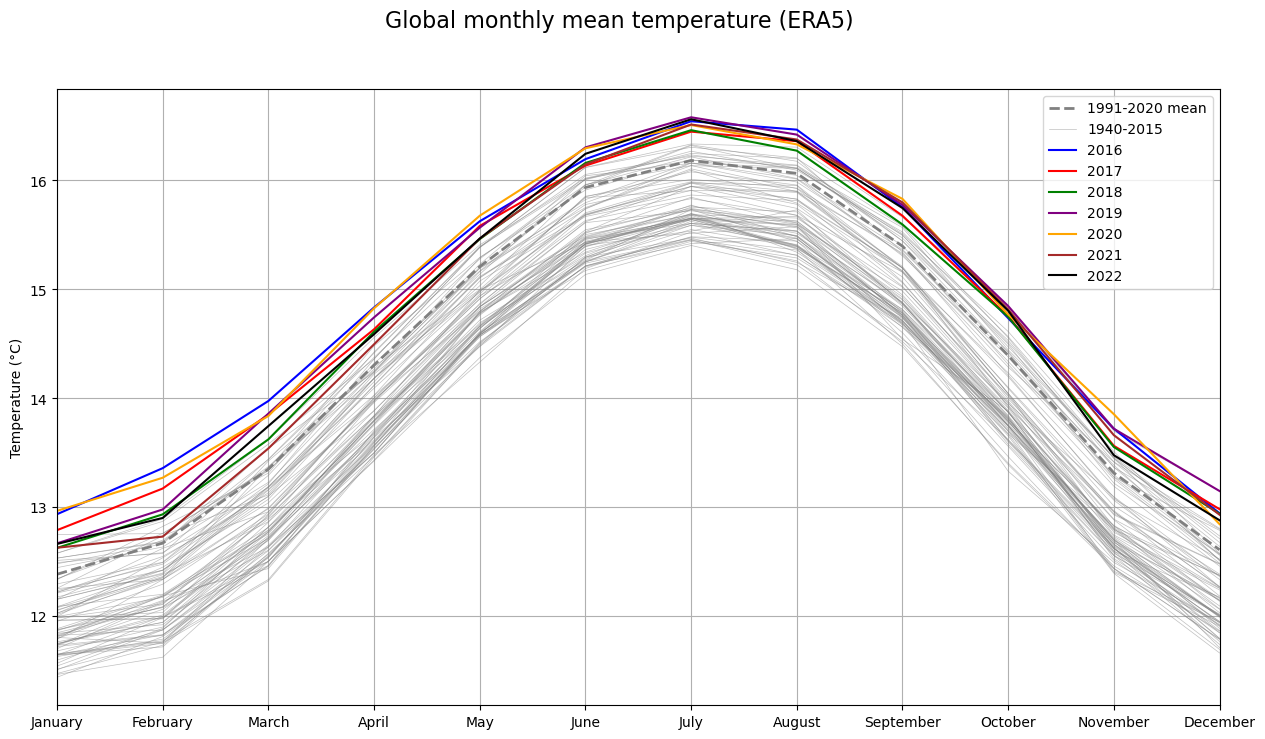

In [45]:
GLOB_month=[]
GLOB_A_month=[]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
fig.suptitle('Global monthly mean temperature (ERA5)', fontsize=16)
#plt.xlabel('Month')
plt.ylabel('Temperature (°C)')

a = 6378.137; e = 1-6356.752**2/a**2; r = np.pi/180 
by_lat = (a*r)**2*(1-e)*np.cos(r*data.latitude)/(1-e*np.sin(r*data.latitude)**2)**2
data_clim=t_clim['t2m'][:,:,:]
glob_clim1 = data_clim.weighted(by_lat).mean({'longitude','latitude'})-273.15
ax.plot(glob_clim1, label='1991-2020 mean', color='grey', linewidth=2, linestyle='--')

print("----- Years 1940-2015 -----")
year_list =[str(i) for i in range(1940,2015)]

for y in tqdm(range(len(year_list))):
    t_year=t.sel(time=year_list[y])
    tanom_year=tanom.sel(time=year_list[y])
    data=t_year['t2m'][:,:,:]
    data_anom=tanom_year['t2m'][:,:,:] 
    glob1 = data.weighted(by_lat).mean({'longitude','latitude'})-273.15
    glob1_anom = data_anom.weighted(by_lat).mean({'longitude','latitude'})
    GLOB_month.append(glob1)
    GLOB_A_month.append(glob1_anom)
    ax.plot(glob1, color='grey', linewidth=0.5, alpha=0.5)

t_year=t.sel(time='2015')
tanom_year=tanom.sel(time=year_list[y])
data=t_year['t2m'][:,:,:]
data_anom=tanom_year['t2m'][:,:,:]
glob1 = data.weighted(by_lat).mean({'longitude','latitude'})-273.15
glob1_anom = data_anom.weighted(by_lat).mean({'longitude','latitude'})
GLOB_month.append(glob1)
GLOB_A_month.append(glob1_anom)
ax.plot(glob1, label='1940-2015', color='grey', linewidth=0.5, alpha=0.5)

print("----- Years 2016-2023 -----")
year_list =[str(i) for i in range(2016,2023)]
colors=['blue', 'red', 'green', 'purple', 'orange', 'brown', 'black']

for y in tqdm(range(len(year_list))):
    t_year=t.sel(time=year_list[y])
    tanom_year=tanom.sel(time=year_list[y])
    data=t_year['t2m'][:,:,:]
    data_anom=tanom_year['t2m'][:,:,:]
    glob1 = data.weighted(by_lat).mean({'longitude','latitude'})-273.15
    glob1_anom = data_anom.weighted(by_lat).mean({'longitude','latitude'})
    GLOB_month.append(glob1)
    GLOB_A_month.append(glob1_anom)
    ax.plot(glob1, label=year_list[y], color=colors[y], linewidth=1.5)

ax.legend()
plt.grid()
plt.xlim(0,11)
x=np.arange(0,12)
plt.xticks(x, months, rotation ='horizontal')
plt.show()

figname='./figs/ERA5_GLOB_T_MONTHLY'
fig.savefig(figname+'.png',bbox_inches='tight')

In [46]:
GLOB_month_series=np.concatenate(GLOB_month)
GLOB_A_month_series=np.concatenate(GLOB_A_month)
print(len(GLOB_month_series))
imonth=int(input("Entrer le numéro du mois souhaité (1-12) : "))
month_data=GLOB_month_series[imonth-1::12]
month_data_anom=GLOB_A_month_series[imonth-1::12]

996
Entrer le numéro du mois souhaité (1-12) : 12


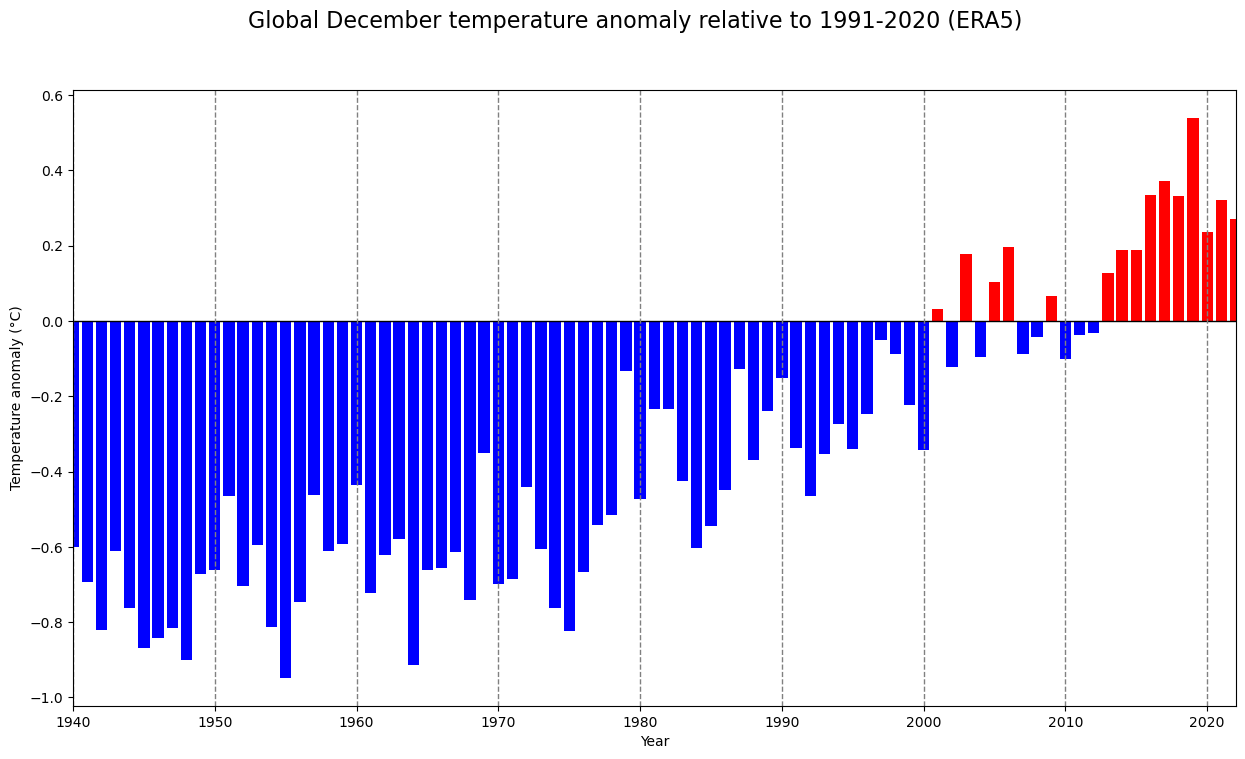

In [47]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
fig.suptitle('Global '+months[imonth-1]+' temperature anomaly relative to 1991-2020 (ERA5)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.axhline(0, linewidth=1, color='k')
plt.xlim(year_int[0],year_int[-1])
colormat=np.where(month_data_anom>0, 'red','blue')
plt.bar(year_int,month_data_anom, color=colormat)
xcoords = np.arange(1940,2030,10)
for xc in xcoords:
    plt.axvline(x=xc,linewidth=1, linestyle='--', color='grey')
plt.show()

figname='./figs/ERA5_GLOB_TANOM_'+months[imonth-1]
fig.savefig(figname+'.png',bbox_inches='tight')

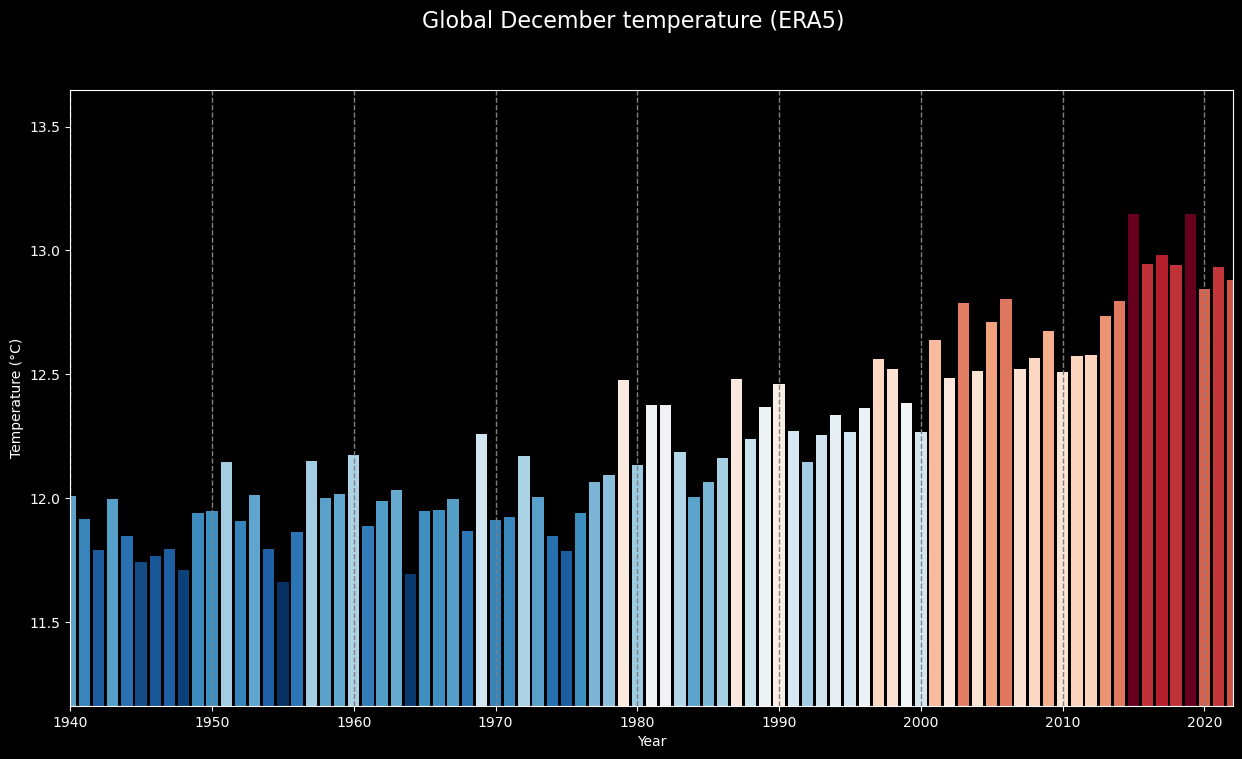

In [48]:
denominator = max(month_data) - min(month_data)
scaled_data = [(datum-min(month_data))/denominator for datum in month_data]
colors = []
cmap = get_cmap('RdBu_r')
for decimal in scaled_data:
    colors.append(cmap(decimal))
    
plt.style.use('dark_background')

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
fig.suptitle('Global '+months[imonth-1]+' temperature (ERA5)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.xlim(year_int[0],year_int[-1])
plt.ylim(min(month_data)-0.5,max(month_data)+0.5)
plt.bar(year_int,month_data, color=colors)

xcoords = np.arange(1940,2030,10)
for xc in xcoords:
    plt.axvline(x=xc,linewidth=1, linestyle='--', color='grey')
plt.show()

figname='./figs/ERA5_GLOB_T_'+months[imonth-1]
fig.savefig(figname+'.png',bbox_inches='tight')

In [ ]:
classement=np.array(np.argsort(month_data))[::-1]
print('Classement '+months[imonth-1]+ ' du plus chaud au plus froid : ',year_int[classement])